# Курсовой проект

# часть1

Описание: по датасету http://www.robots.ox.ac.uk/~vgg/data/bicos/data/oxfordflower102.tar. Определение маски изображения объекта (изначально предполагалось генерация объекта но ресурсы не позволили).

        

In [33]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt


import tensorflow as tf
import os

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [34]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='http://www.robots.ox.ac.uk/~vgg/data/bicos/data/oxfordflower102.tar',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

C:\Users\Cats\.keras\datasets\flower_photos


In [35]:
list_dir=[]
for item in data_root.iterdir():
    list_dir.append(item)
    print(item)

C:\Users\Cats\.keras\datasets\flower_photos\bicos
C:\Users\Cats\.keras\datasets\flower_photos\bicos-mt
C:\Users\Cats\.keras\datasets\flower_photos\imagelabels.mat
C:\Users\Cats\.keras\datasets\flower_photos\jpg
C:\Users\Cats\.keras\datasets\flower_photos\set.mat


In [36]:
list_file_name=os.listdir(list_dir[0])
all_image_paths=[]
for name in list_file_name:
    all_image_paths.append(f'{str(list_dir[3])}\\{str.split(name,".")[0]}.jpg')

In [37]:
all_image_mask = list(data_root.glob('bicos/*'))


#all_image_paths = [str(path) for path in all_image_paths]
all_image_mask = [str(path) for path in all_image_mask]
#random.shuffle(all_image_paths)
print(len(all_image_paths))
print(len(all_image_mask))


2040
2040


In [38]:
split_index=40
train_path=all_image_paths[:-split_index]
train_path_mask=all_image_mask[:-split_index]
test_path=all_image_paths[-split_index:]
test_path_mask=all_image_mask[-split_index:]



In [39]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [40]:
def preprocess_image(image,channels=3):
  image = tf.image.decode_jpeg(image, channels=channels)
  image = tf.image.resize(image, [128, 128])
  image /= 255.0  # normalize to [0,1] range

  return image

In [41]:
def load_and_preprocess_image(path,channels=3):
  image = tf.io.read_file(path)
  return preprocess_image(image,channels)

In [42]:
def load_and_preprocess_mask(path,channels=1):
  image = tf.io.read_file(path)
  return preprocess_image(image,channels)

In [43]:
def split_train_test(all_image_paths,split_index=40):
    train_path=all_image_paths[:-split_index]
    train_path_mask=all_image_mask[:-split_index]
    test_path=all_image_paths[-split_index:]
    test_path_mask=all_image_mask[-split_index:]
    path_train = tf.data.Dataset.from_tensor_slices(train_path)
    path_train_mask = tf.data.Dataset.from_tensor_slices(train_path_mask)
    path_test = tf.data.Dataset.from_tensor_slices(test_path)
    path_test_mask = tf.data.Dataset.from_tensor_slices(test_path_mask)
    
    train_ds = path_train.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    train_mask_ds=path_train_mask.map(load_and_preprocess_mask, num_parallel_calls=AUTOTUNE)
    
    test_ds = path_test.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    test_mask_ds=path_test_mask.map(load_and_preprocess_mask, num_parallel_calls=AUTOTUNE)
    
    return tf.data.Dataset.zip((train_ds, train_mask_ds)), tf.data.Dataset.zip((test_ds, test_mask_ds))    

In [44]:
train, test=split_train_test(all_image_paths)


In [45]:
image_count=len(all_image_paths)-40
test_size=40

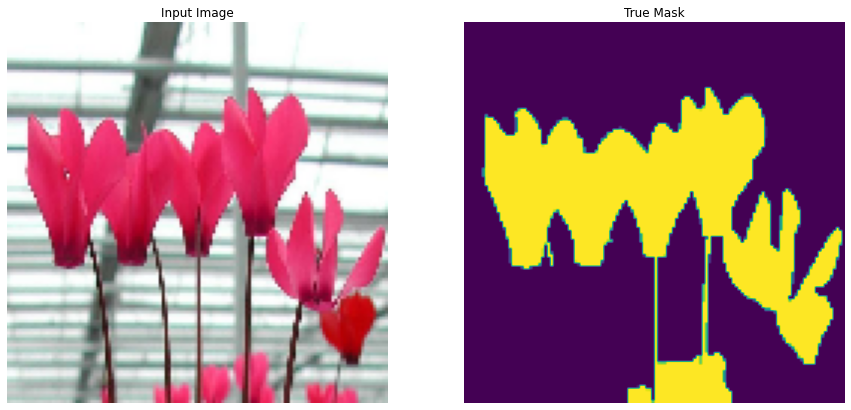

In [48]:
for image, mask in train.take(50):
      sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [49]:
BATCH_SIZE = 32
buffer_size=image_count

# Установка размера буфера перемешивания, равного набору данных, гарантирует
# полное перемешивание данных.
train = train.shuffle(buffer_size=buffer_size)
train = train.repeat()
train = train.batch(BATCH_SIZE)
# `prefetch` позволяет датасету извлекать пакеты в фоновом режиме, во время обучения модели.
train = train.prefetch(buffer_size=AUTOTUNE)


In [50]:
test = test.repeat()
test = test.batch(BATCH_SIZE)
# `prefetch` позволяет датасету извлекать пакеты в фоновом режиме, во время обучения модели.
test = test.prefetch(buffer_size=AUTOTUNE)

In [70]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = [
    'block_1_expand',   # 64x64
    'block_3_expand',   # 32x32
    'block_6_expand',   # 16x16
    'block_13_expand',  # 8x8
    ]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [71]:
up_stack = [
   
   pix2pix.upsample(256, 3),  # 8x8 -> 16x16
 
   pix2pix.upsample(128, 3),  # 16x16 -> 32x32 
 
   pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [72]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [73]:
OUTPUT_CHANNELS = 3
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [74]:
TRAIN_LENGTH = image_count
BATCH_SIZE = 32
BUFFER_SIZE = image_count
STEPS_PER_EPOCH =  TRAIN_LENGTH // BATCH_SIZE
STEPS_PER_EPOCH

62

In [75]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [76]:
def show_predictions(dataset=None, num=1):
 
    display([sample_image, sample_mask,
    create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [77]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

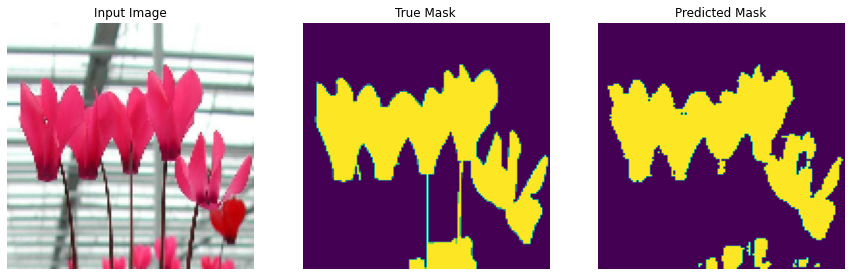


Sample Prediction after epoch 10

62/62 [==============================] - 12s 196ms/step - loss: 0.1363 - accuracy: 0.9444 - val_loss: 0.1753 - val_accuracy: 0.9302


In [80]:
EPOCHS = 10 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS =10# test_size//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test,
                          callbacks=[DisplayCallback()])

### Вывод: использован датасет http://www.robots.ox.ac.uk/~vgg/data/bicos/data/oxfordflower102.tar. использована сеть MobilNetV2, Проверена сеть EffishionNet Наилучшее соотношение скорость качество показала MobilNetV2.  увеличено количество эпох обучения. val_accuracy: 0.9302 

# Часть 2

# DISN: Deep Implicit Surface Network for High-quality Single-view 3D Reconstruction

Обзор:

ссылка на статью https://arxiv.org/abs/1905.10711

Цель данной статьи работы по реконструкции поверхности 3D обьекта.
По изображению объекта восстановить трехмерную форму, которая захватывает как общую
структура и мелкие детали объекта. Рассматривается моделирование 3D-формы как расстояние со знаком.
функция (SDF). Как показано на рисунке SDF - это непрерывная функция, отображающая заданное пространственное
точка p = (x; y; z) 2 R3 на действительное значение s 2 R: s = SDF (p): Вместо более обычного 3D
таких представлений, как глубина, абсолютное значение s указывает расстояние от точки до
поверхность, а знак s указывает, находится ли точка внутри или вне.

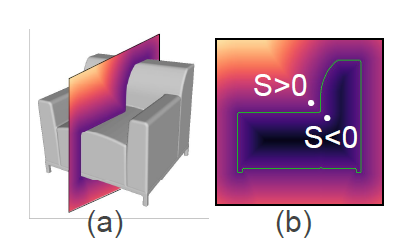

проблема определения 3D поверхности состоит в не просто определения признаков общих для объекта, а также определение конфигурации самого объекта. Данное решение состоит из выделения глобальных признаков и отдельного выделения локальных признаков с последующим их объединением. Дополнительно оцениваем положение камеры.

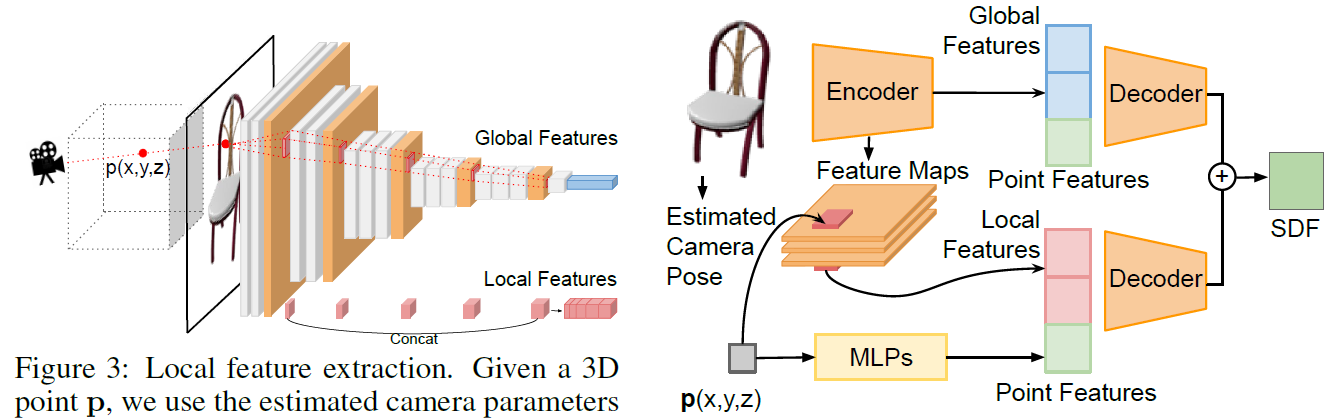

в итоге пространство признаков распределяется как объединение глобальных, локальных и положение камеры признаков.

положительные стороны данной архитектуры- оценка и представление объекта модели происходит с учетом его локальных особенностей(конфигурации)
в рамках определенного класса.

отрицательные: ресурсоемкость т.к. к пространству признаков добавляются положения камеры.

Пример определения поверхности представлен на рисунке ниже. Как видно хорошо определены особености объекта.

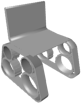

 Данная архитектура не работает с текстурами объектов, но авторы обещают реализовать данную возможность.

#### Итого: Применение двух моделей CNN для разделения признаков принадлежащих классу объектов и признаков являющихся особенностью объекта позволяеет более качественно построить 3D модель объета.